# Reproduce extraction & graph creation


## Extract incidents
- Extract incidents and alerts from the alphine ski house data and save them to csv.

In [7]:
import pandas as pd
import os
import json


# load data
base_path = "../env/data/alphineskihouse/"
incident_path = os.path.join(base_path, "SecurityIncident.csv")
sep = "❖"
security_incident = pd.read_csv(incident_path, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
alert_path_1 = os.path.join(base_path, "SecurityAlert/SecurityAlert_0.csv")
alert_path_2 = os.path.join(base_path, "SecurityAlert/SecurityAlert_1.csv")
security_alert =  pd.read_csv(alert_path_1, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert_2 = pd.read_csv(alert_path_2, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert = pd.concat([security_alert, security_alert_2])


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# ----------------------------filter_incidents--------------------------
# sort by time
security_incident["TimeGenerated"] = pd.to_datetime(security_incident["TimeGenerated"], format='mixed')
security_incident = security_incident.sort_values(by="TimeGenerated")

security_alert["TimeGenerated"] = pd.to_datetime(security_alert["TimeGenerated"], format='mixed')
security_alert = security_alert.sort_values(by="TimeGenerated")


# 1. Filter by LATEST label
filtered_incidents = []
for i, incident in security_incident.iterrows():
    labels = json.loads(incident['Labels'])
    # check if the incident is the latest in one line
    is_latest = any([label['labelName'] == 'LATEST' for label in labels])
    if is_latest:
        filtered_incidents.append(incident)

filtered_incidents = pd.DataFrame(filtered_incidents)

# unique incident numbers
incident_numbers = filtered_incidents['IncidentNumber'].unique()


# 2. for each incdent number, get the latest incident generated and put in a new dataframe
latest_incidents = []
for incident_number in incident_numbers:
    incident = filtered_incidents[filtered_incidents['IncidentNumber'] == incident_number]
    latest_incidents.append(incident.iloc[-1])
    
latest_incidents = pd.DataFrame(latest_incidents)


start_time = pd.to_datetime("2024-06-18T00:00:00Z")
end_time = pd.to_datetime("2024-07-23T00:00:00Z")
latest_incidents["FirstActivityTime"] = pd.to_datetime(latest_incidents["FirstActivityTime"], format='mixed')
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] > start_time]
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] < end_time]

print("Num of incidents extracted: ", len(latest_incidents))


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# -----------------------save extracted incidents-----------------------
def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

output_path = "./extracted_incidents.csv"
latest_incidents.to_csv(output_path, index=False, encoding='utf-8')

all_alerts = []
for _, incident in latest_incidents.iterrows():
    alert_ids = json.loads(incident['AlertIds'])
    alerts = extract_alert(alert_ids, security_alert)
    all_alerts.extend(alerts)

all_alerts = pd.DataFrame(all_alerts)
output_path = "./extracted_alerts.csv"
all_alerts.to_csv(output_path, index=False, encoding='utf-8')



Num of incidents extracted:  8


## Construct graphs from incidents
- Load the saved incidents and alerts
- Construct a graph from the incidents and alerts, only save the largest connected component from one incident.
- Save to graphml format.

In [8]:
import pandas as pd
import os
import json
from secgym.qagen.alert_graph import AlertGraph

def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

def get_incident_alert_pairs(path="./"):
    with open(os.path.join(path, "extracted_incidents.csv")) as f:
        incidents = pd.read_csv(f)
    
    with open(os.path.join(path, "extracted_alerts.csv")) as f:
        all_alerts = pd.read_csv(f)

    incident_alert_pairs = []
    for _, incident in incidents.iterrows(): 
        alert_ids = json.loads(incident['AlertIds'])
        alerts = extract_alert(alert_ids, all_alerts)
        incident_alert_pairs.append((incident, alerts))

    return incident_alert_pairs


incident_alert_pairs = get_incident_alert_pairs()


for i in range(len(incident_alert_pairs)):
    a, b = incident_alert_pairs[i]
    alert_graph = AlertGraph()

    inumber = incident_alert_pairs[i][0]["IncidentNumber"]
    alert_graph.build_graph_from_incident_alert(a,b)
    alert_graph.save_to_graphml(filepath=f"./graph_files/incident_{inumber}.graphml")


Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files/incident_5.graphml
Graph saved to ./graph_files/incident_38.graphml
Graph saved to ./graph_files/incident_34.graphml
Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files/incident_39.graphml
Graph saved to ./graph_files/incident_55.graphml
Graph saved to ./graph_files/incident_122.graphml
Graph saved to ./graph_files/incident_134.graphml
Graph saved to ./graph_files/incident_166.graphml


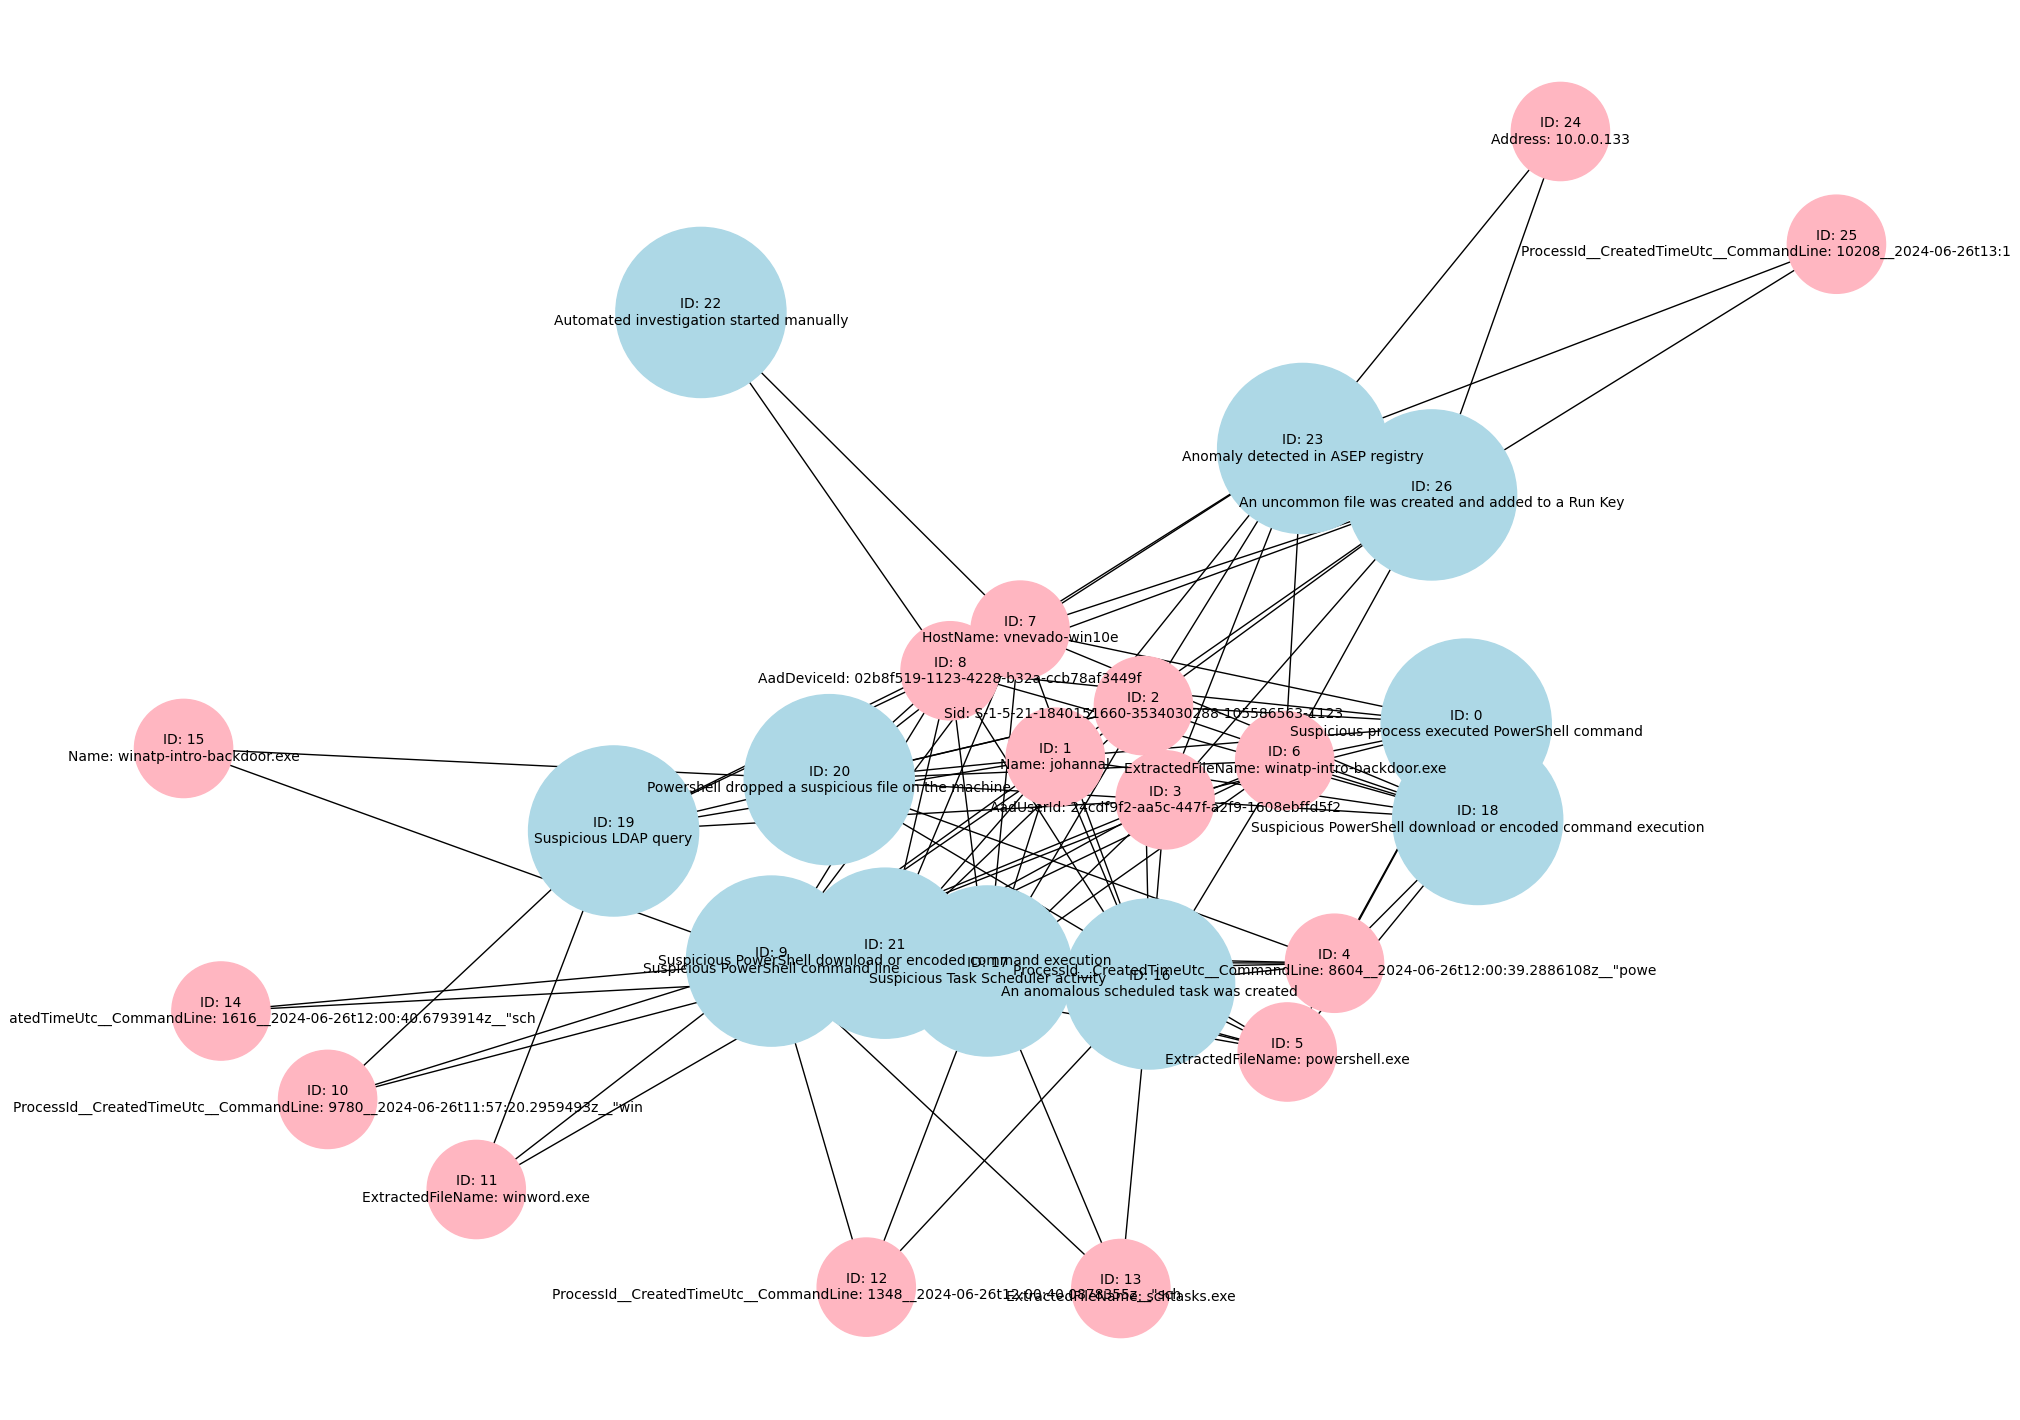

In [3]:
a, b = incident_alert_pairs[2]
alert_graph = AlertGraph()
alert_graph.build_graph_from_incident_alert(a,b)
alert_graph.save_to_graphml(filepath=f"./graph_files/")